# LLM 에이전트 팀과 함께 복잡한 분석 완료하기

<img src="../cover.png" 
     alt="NLP와 LLM 실전 가이드(한빛미디어)"
     style="border: 3px solid gray; box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.3); border-radius: 10px; width: 300px;" width="300">


* 저자:  
    - [Lior Gazit](https://www.linkedin.com/in/liorgazit).  
    - [Meysam Ghaffari](https://www.linkedin.com/in/meysam-ghaffari-ph-d-a2553088/).
* 역자:
    - [박조은](https://github.com/corazzon)
* 이 노트북은 다음의 책에서 소개하는 내용입니다.
    - 역서 : NLP와 LLM 실전 가이드(한빛미디어)
    - 원서 : [Mastering NLP from Foundations to LLMs](https://www.amazon.com/dp/1804619183)

colab 실습 : 
https://github.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/Mastering-NLP-from-Foundations-to-LLMs/blob/main/Chapter9_notebooks/Ch9_Completing_a_Complex_Analysis_with_a_Team_of_LLM_Agents.ipynb)  


원서 Colab 실습 : 
https://github.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs   
<a target="_blank" href="https://colab.research.google.com/github/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/blob/liors_branch/Chapter9_notebooks/Ch9_Completing_a_Complex_Analysis_with_a_Team_of_LLM_Agents.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**이 노트북의 목적:**
다음은 각기 다른 역할을 맡은 **복수 에이전트 팀**이 전문가 팀으로서 어떻게 기능할 수 있는지 보여드립니다. 우리가 선택한 사례는 이전에 실행했던 코드의 연장선상에 있습니다:
**Ch9_RAGLlamaIndex_Prompt_Compression.ipynb**

이전 코드에서는 프롬프트 압축 활용에 대한 복잡한 평가를 수행했고, 코드 완료 시 두 가지 결과물이 있었습니다. 하나는 `record`라 불리는 실험의 수치 측정값을 담은 딕셔너리이고, 다른 하나는 일치율, 토큰 및 비용 감소, 처리 시간 변화에 대한 서술적 진술입니다.

이전 노트북에서는 의도적으로 중단했습니다. 토큰과 비용 감소를 시각화하지 않았고, 프롬프트 축소 적용에 대한 의견도 형성하지 않았습니다. 이제 그 평가 결과를 가지고 에이전트 팀에게 시각화와 결론 도출을 맡기려 합니다!

**참조:**
이 노트북은 Microsoft의 저장소를 기반으로 제작되었습니다:
https://github.com/microsoft/autogen

**요구사항:**
* Colab에서 실행 시, 다음 런타임 노트북 설정 사용: `Python3, CPU`
* 이 코드는 LLM으로 OpenAI의 API를 선택하므로 유료 **API 키**가 필요합니다.

>*```면책사항: 이 노트북에서 다루는 내용과 아이디어는 저자들 개인의 것이며, 저자들의 고용주의 견해나 지적 재산을 대변하지 않습니다.```*

설치 :

In [2]:
# 참고사항:
# 아래 코드가 Python 패키지 의존성 문제로 오류가 발생하면, 이는 새로운 버전의 영향일 수 있습니다.
# 이럴 때 default_installations를 False로 설정하여 원저자가 설정한 의존성을 따르게 할 수 있습니다.
default_installations = True
if default_installations:
    !pip -q install pyautogen
else:
    import requests
    text_file_path = "requirements__Ch9_Completing_a_Complex_Analysis_with_a_Team_of_LLM_Agents.txt"
    url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/" + text_file_path
    res = requests.get(url)
    with open(text_file_path, "w") as f:
        f.write(res.text)

    !pip install -r requirements__Ch9_Completing_a_Complex_Analysis_with_a_Team_of_LLM_Agents.txt

Imports:

In [19]:
# autogen 의존 라이브러리 설치
!pip install -q dask
# 한글 폰트 시각화를 위해 설치
!pip install -q koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 39.9 MB/s eta 0:00:00


In [4]:
import autogen

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


코드 설정:

OpenAI API key:  
**문자열 형태로 아래 "..."에 OpenAI에서 발급받은 key를 입력해 주세요!**  


Colab 보안 비밀 설정은 왼쪽 열쇠 모양의 아이콘을 클릭하면 나옵니다.
<img src="https://i.imgur.com/7P383n4.png" width="500">

유료 LLM이 아닌 무료 LLM을 활용하고자 한다면, 책에서 설명하는 허깅페이스를 활용하는 예제를 따라 대체 방법을 사용해 보세요.

In [5]:
api_key = "..."

In [6]:
# Colab 에서는 보안 비밀키 설정을 통해 API 키를 매번 입력하지 않고 아랴와 같이 관리할 수 있습니다.
try:
    from google.colab import userdata
    api_key = userdata.get('OPENAI_API_KEY')
    if not api_key:
        raise ValueError("Colab의 보안 비밀 설정에서 'OPENAI_API_KEY'를 찾을 수 없습니다.")
except ImportError:
    print("Colab 환경이 아니므로, 'api_key' 변수에 직접 값을 할당해야 합니다.")

AutoGen의 요구 사항에 따라 구성 딕셔너리를 정의하세요.
더 많은 세부 정보와 옵션은 다음 링크에서 확인할 수 있습니다:  
https://github.com/microsoft/autogen/blob/main/notebook/config_loader_utility_functions.ipynb

In [7]:
gpt_type = "gpt-4o-mini"  # 사용할 GPT 모델 유형을 설정

config_list = autogen.get_config_list(
    [api_key],  # API 키 목록을 전달
    base_urls=None,  # 필요한 경우 API 기본 URL을 지정할 수 있음 (예: localhost:8000)
    api_type="openai",  # API 유형을 지정 (예: "openai" 또는 "aoai")
    api_version=None,  # 필요한 경우 API 버전을 지정할 수 있음
)
config_list[0]["model"] = gpt_type  # 설정 목록에서 사용할 모델을 지정
llm_config = {"config_list": config_list}  # LLM 구성 정보를 딕셔너리로 저장

## 실험 결과 시각화  
파일 [record.pickle](https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/record.pickle)은 dict 변수로, 이전 평가 노트북에서 얻은 수치 결과가 담긴 컬렉션입니다. 여기서는 각 실험별 토큰 수의 분포를 시각화하고자 합니다. 실험에는 원본 프롬프트의 토큰 수, 압축된 프롬프트의 토큰 수가 있으며, 두 값의 비율도 각 실험마다 포함되어 있습니다.

이 섹션에서는 코드 작성 팀을 구성해 이 세 가지의 분포를 시각화할 수 있도록 하겠습니다.

### 팀이 수행할 작업 정의하기

In [8]:
plot_task = """다음 URL에 있는 Python 딕셔너리를 참조하세요: <https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/record.pickle>. 이 딕셔너리의 변수명은 'record'입니다.

딕셔너리의 세 필드('original_tokens', 'compressed_tokens', 'ratios')를 분석해주세요.
이 세 컬럼을 딕셔너리에서 Pandas DataFrame으로 변환하여 다음 작업을 수행하세요.

각 행은 프롬프트 토큰이 압축되는 실험을 나타냅니다.
각 실험에서 딕셔너리에 기록되는 3가지 값은 다음과 같습니다:
- 'original_tokens': 원본 프롬프트의 토큰 수
- 'compressed_tokens': 압축 후 프롬프트의 토큰 수
- 'ratios': 두 값의 비율 (original_tokens/(compressed_tokens + 1))

Python으로 다중 플롯을 설계하는 것이 당신의 임무입니다.
다중 플롯은 상단과 하단, 두 개의 그림으로 구성됩니다:
- 상단: 'original_tokens'와 'compressed_tokens' 두 데이터 필드의 빈도 분포
- 하단: 'ratios'의 빈도 분포

각 서브플롯의 축, 범례, 제목을 적절히 라벨링하세요."""

### 에이전트 정의 및 팀원 역할 할당하기
이 작업을 위해서는 세 명의 팀원이 필요합니다. 코드를 작성할 프로그래머, 코드를 실행하고 피드백을 제공할 QA 엔지니어, 그리고 작업 완료 여부를 확인할 팀 리더입니다.

In [9]:
programmer = autogen.AssistantAgent(
    name="programmer",
    llm_config=llm_config,
    system_message="""
        당신은 경험 많고 전문적인 Python 프로그래머입니다. 잡담은 금지입니다.
        모든 대화는 매우 짧고 간결하게 유지하세요!
        """,
)

qa_engineer = autogen.AssistantAgent(
    name="qa_engineer",
    llm_config=llm_config,
    system_message="""
        당신은 경험 많고 전문적인 Python 프로그래머입니다.
        특히 코드를 실행하고 오류와 버그의 원인을 파악하는 데 능숙합니다.
        문제를 해결할 수 있도록 다른 에이전트들에게 이를 명확히 전달합니다.
        작업이 모두 완료되면 단 한 단어, "TERMINATE"만 답변하세요. 잡담은 금지입니다.
        시각화는 한국어로 하고
        koreanize_matplotlib 을 설치하고 불러와서 한글 폰트 설정을 해주세요.
        모든 대화는 매우 짧고 간결하게 유지하세요!
        """,
    code_execution_config={
        "last_n_messages": 10,
        "work_dir": "tasks",
        "use_docker": False,
    },)


lead = autogen.UserProxyAgent(
    name="lead",
    human_input_mode="NEVER",
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 10,
        "work_dir": "tasks",
        "use_docker": False,
    },)

### 그룹 간 대화 정의

In [10]:
groupchat_0 = autogen.GroupChat(agents=[programmer, qa_engineer],
                                speaker_selection_method='auto',
                                allow_repeat_speaker=False,
                                messages=[],
                                max_round=10)

manager_0 = autogen.GroupChatManager(
    groupchat=groupchat_0,
    name="manager_0",
    llm_config={"config_list": config_list},
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "tasks",
        "use_docker": False,
    },
)

### 팀 배치하기

In [11]:
lead.initiate_chats(
    [
        {"recipient": manager_0, "message": plot_task, "summary_method": "reflection_with_llm", "clear_history": True},
    ]
)


********************************************************************************
Starting a new chat....

********************************************************************************
lead (to manager_0):

다음 URL에 있는 Python 딕셔너리를 참조하세요: <https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/record.pickle>. 이 딕셔너리의 변수명은 'record'입니다.

딕셔너리의 세 필드('original_tokens', 'compressed_tokens', 'ratios')를 분석해주세요.
이 세 컬럼을 딕셔너리에서 Pandas DataFrame으로 변환하여 다음 작업을 수행하세요.

각 행은 프롬프트 토큰이 압축되는 실험을 나타냅니다.
각 실험에서 딕셔너리에 기록되는 3가지 값은 다음과 같습니다:
- 'original_tokens': 원본 프롬프트의 토큰 수
- 'compressed_tokens': 압축 후 프롬프트의 토큰 수
- 'ratios': 두 값의 비율 (original_tokens/(compressed_tokens + 1))

Python으로 다중 플롯을 설계하는 것이 당신의 임무입니다.
다중 플롯은 상단과 하단, 두 개의 그림으로 구성됩니다:
- 상단: 'original_tokens'와 'compressed_tokens' 두 데이터 필드의 빈도 분포
- 하단: 'ratios'의 빈도 분포

각 서브플롯의 축, 범례, 제목을 적절히 라벨링하세요.

--------------------------------------------------------------------------------

Next speake

[ChatResult(chat_id=None, chat_history=[{'content': "다음 URL에 있는 Python 딕셔너리를 참조하세요: <https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/record.pickle>. 이 딕셔너리의 변수명은 'record'입니다.\n\n딕셔너리의 세 필드('original_tokens', 'compressed_tokens', 'ratios')를 분석해주세요.\n이 세 컬럼을 딕셔너리에서 Pandas DataFrame으로 변환하여 다음 작업을 수행하세요.\n\n각 행은 프롬프트 토큰이 압축되는 실험을 나타냅니다.\n각 실험에서 딕셔너리에 기록되는 3가지 값은 다음과 같습니다:\n- 'original_tokens': 원본 프롬프트의 토큰 수\n- 'compressed_tokens': 압축 후 프롬프트의 토큰 수\n- 'ratios': 두 값의 비율 (original_tokens/(compressed_tokens + 1))\n\nPython으로 다중 플롯을 설계하는 것이 당신의 임무입니다.\n다중 플롯은 상단과 하단, 두 개의 그림으로 구성됩니다:\n- 상단: 'original_tokens'와 'compressed_tokens' 두 데이터 필드의 빈도 분포\n- 하단: 'ratios'의 빈도 분포\n\n각 서브플롯의 축, 범례, 제목을 적절히 라벨링하세요.", 'role': 'assistant', 'name': 'lead'}], summary='The user successfully executed a Python script to fetch data from a URL, convert it to a Pandas DataFrame, and create a multi-plot visualization. However, the output indicates that succ

### 프로그래머가 작성한 코드 실행하기

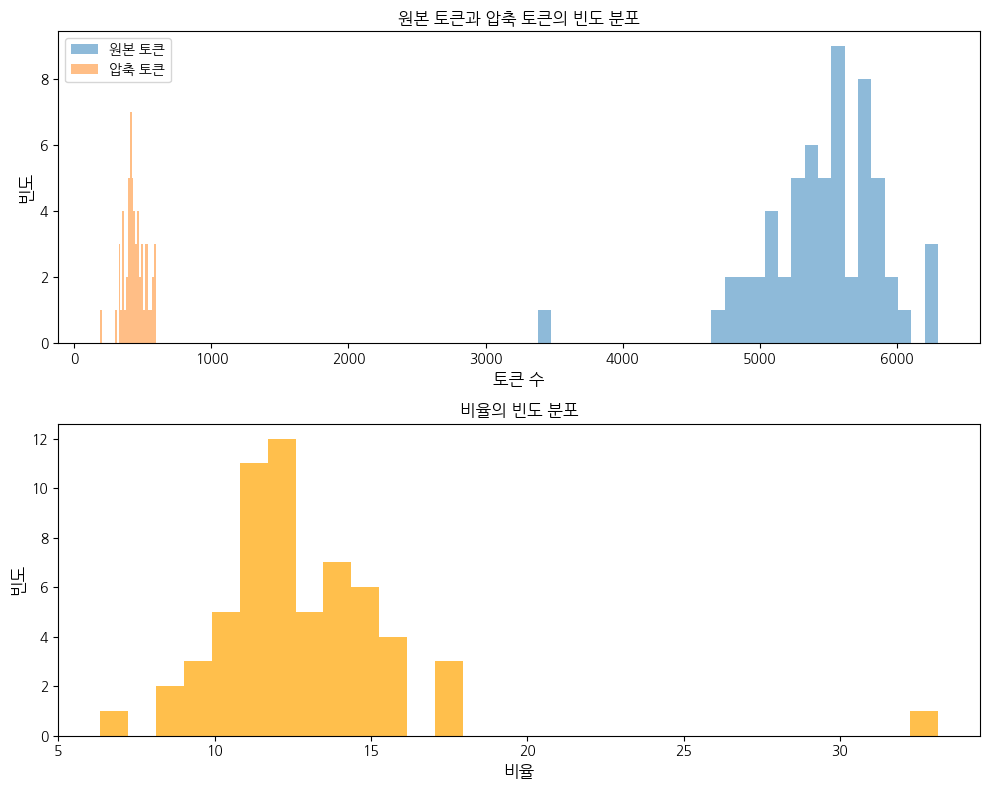

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import requests
import pickle

# 데이터 가져오기
url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter9_notebooks/record.pickle"
response = requests.get(url)
record = pickle.loads(response.content)

# 딕셔너리에서 DataFrame으로 변환
df = pd.DataFrame(record)

# ratios 계산
df['ratios'] = df['original_tokens'] / (df['compressed_tokens'] + 1)

# 다중 플롯 생성
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# 상단: original_tokens와 compressed_tokens의 빈도 분포
axs[0].hist(df['original_tokens'], bins=30, alpha=0.5, label='원본 토큰')
axs[0].hist(df['compressed_tokens'], bins=30, alpha=0.5, label='압축 토큰')
axs[0].set_title('원본 토큰과 압축 토큰의 빈도 분포')
axs[0].set_xlabel('토큰 수', fontsize=12)
axs[0].set_ylabel('빈도', fontsize=12)
axs[0].legend()

# 하단: ratios의 빈도 분포
axs[1].hist(df['ratios'], bins=30, color='orange', alpha=0.7)
axs[1].set_title('비율의 빈도 분포')
axs[1].set_xlabel('비율', fontsize=12)
axs[1].set_ylabel('빈도', fontsize=12)

plt.tight_layout()
plt.show()


## 실험 결과 검토 및 신중한 결론 도출  
특정 기능의 영향을 평가하기 위해 복잡한 실험을 수행했듯이, 이제 실험 결과를 정성적으로 요약하고, 이를 바탕으로 기업의 의사결정권자나 학계 연구자들에게 적합한 결론을 제시하려고 합니다.

이 과정에서 중요한 점은 결론을 도출하는 작업이 수학적 또는 알고리즘적 모델에 맡겨진 적이 없다는 것입니다. 다양한 평가를 진행하고 이를 자동화하여 최종 결론 도출에 필요한 데이터를 제공할 수는 있지만, 최종적인 판단과 결론을 내리는 것은 여전히 인간의 역할입니다.


### 팀이 수행할 작업 정의하기

In [13]:
description_of_true_results = """
LLMLingua를 사용한 프롬프트 압축의 품질과 영향을 평가하기 위한 실험이 완료되었습니다.
다음은 결과에 대한 기술적 요약입니다:

1. 분류 성능
압축된 컨텍스트가 분류 성능에 미치는 영향을 측정했습니다.
다른 모든 조건은 동일하게 유지하면서, 동일한 프롬프트와 동일한 LLM을 사용하여 원본 컨텍스트를 활용한 경우와 압축된 컨텍스트를 활용한 경우의 일치율을 비교했습니다:
- 일치: 총 60건 중 55건
- 불일치: 총 60건 중 5건
- 일치율: 92%

2. 자원 절감: 전송된 토큰 수 감소는 비용($) 절감으로 직결됩니다.
이번 실험에서 반환된 응답은 단일 단어(즉, 단일 토큰)로, RAG의 두 경우에서 반환된 토큰 수는 동일하므로 이를 평가할 필요는 없습니다:
- 압축되지 않은 경우: 60번 호출에서 전송된 총 토큰 수: 327,654
- 압축된 경우: 60번 호출에서 전송된 총 토큰 수: 26,473
- 토큰 감소율: 92%
- 압축 비율: 12.50배

3. 처리 시간:
- 압축되지 않은 경우: 60번 호출의 총 실행 시간: 76초
- 압축된 경우: 60번 호출의 총 실행 시간: 839초
"""


description_of_bad_results = """
LLMLingua를 사용한 프롬프트 압축의 품질과 영향을 평가하기 위한 실험이 완료되었습니다.
다음은 결과에 대한 기술적 요약입니다:

1. 분류 성능
압축된 컨텍스트가 분류 성능에 미치는 영향을 측정했습니다.
다른 모든 조건은 동일하게 유지하면서, 동일한 프롬프트와 동일한 LLM을 사용하여 원본 컨텍스트를 활용한 경우와 압축된 컨텍스트를 활용한 경우의 일치율을 비교했습니다:
- 일치: 총 60건 중 14건
- 불일치: 총 60건 중 46건
- 일치율: 23%

2. 자원 절감: 전송된 토큰 수 감소는 비용($) 절감으로 직결됩니다.
이번 실험에서 반환된 응답은 단일 단어(즉, 단일 토큰)로, RAG의 두 경우에서 반환된 토큰 수는 동일하므로 이를 평가할 필요는 없습니다:
- 압축되지 않은 경우: 60번 호출에서 전송된 총 토큰 수: 327,654
- 압축된 경우: 60번 호출에서 전송된 총 토큰 수: 264,730
- 토큰 감소율: 19%
- 압축 비율: 1.23배

3. 처리 시간:
- 압축되지 않은 경우: 60번 호출의 총 실행 시간: 76초
- 압축된 경우: 60번 호출의 총 실행 시간: 839초
"""

In [14]:
conclusion_task_template = """아래에 출력된 결과를 참고하세요.
이 결과는 대화의 이전 부분에서 실행된 실험에서 나온 결과입니다.
이 실험은 프롬프트 압축이 다양한 지표에 미치는 영향을 조사한 것입니다.
txt 파일에 나타난 결과를 읽고, 작성자가 프롬프트 압축 사용의 가치와 장단점에 대해 결론 형식의 간략한 요약을 작성하게 하세요.
결론은 여러 문장으로 구성되며, 각 문장은 새 줄로 구분되어야 합니다.
마지막 줄에는 프롬프트 압축 방법이 추천되는지 아니면 추천되지 않는지를 명시적으로 언급해야 합니다!
작성자는 주요 논점과 핵심 결론을 간결한 불릿 포인트 형식으로 작성해야 합니다.
principal_engineer는 비평가로서 높은 기준을 설정해야 합니다.
여기 결과가 있습니다:
{
<results>
}"""
conclusion_task_true_results = conclusion_task_template.replace("<results>", description_of_true_results)
conclusion_task_bad_results = conclusion_task_template.replace("<results>", description_of_bad_results)

### 에이전트 정의 및 팀원 역할 할당  
이 작업을 위해 세 명의 팀원이 필요합니다.  
- **Principal Engineer**: 경험 많고 숙련된 기술 전문가로, 분석과 피드백을 담당합니다.  
- **Technical Writer**: Principal Engineer의 피드백을 바탕으로 결론을 작성하는 역할을 맡습니다.  
- **Team Lead**: 작업이 완료되었는지 확인하는 역할을 하며, 이는 이전 작업에서 이미 정의된 바 있습니다.

In [15]:
principal = autogen.AssistantAgent(
    name="principal_engineer",
    llm_config=llm_config,
    system_message="""
        당신은 경험 많고 전문적인 머신러닝 엔지니어입니다.
        새로운 기능과 알고리즘을 분석하고, 이를 기반으로 최고기술책임자(CTO)에게 심도 있는 의견을 제출합니다.
        모든 결론은 분석과 실험에서 도출된 수치와 기술적 근거를 바탕으로 작성됩니다.
        Python 코딩 기술을 사용해 파일을 가져올 수 있습니다.
        txt 파일을 가져올 때는 그 내용을 다른 사람들이 볼 수 있도록 출력합니다!
        요약이 완전히 작성되고 당신의 기준을 충족하기 전까지는 작업이 완료되지 않습니다!
        작업 완료 여부를 판단하려면 체크리스트를 검증해야 합니다: 모든 주장은 간결하고 명확하며, 각 주장은 실험 또는 결과에서 계산된 수치로 뒷받침되어야 합니다.
        모든 대화는 매우 짧고 간결하게 유지하세요!
        작업이 완료되고 기준을 충족하면 "TERMINATE"라고 응답하세요!
        """,
)

writer = autogen.AssistantAgent(
    name="writer",
    llm_config=llm_config,
    system_message="""
        당신은 통찰력 있고 매력적인 요약 작성으로 유명한 전문 작가입니다.
        principal_engineer와 협력하여 통찰력 있는 콘텐츠를 만듭니다.
        principal_engineer가 실험 결과를 출력하기 전까지는 요약 작성을 시작하지 않습니다!
        필요한 파일이나 데이터가 있을 경우, principal_engineer에게 요청합니다.
        복잡한 개념을 설득력 있는 서술로 변환하는 데 능숙합니다.
        """,
)

### 그룹 간 대화 정의

In [16]:
groupchat_1 = autogen.GroupChat(agents=[writer, principal],
                                speaker_selection_method='auto',
                                messages=[],
                                max_round=50)

manager_1 = autogen.GroupChatManager(
    groupchat=groupchat_1,
    name="manager_1",
    llm_config={"config_list": config_list},
    is_termination_msg=lambda x: x.get("content", "").find("TERMINATE") >= 0,
    code_execution_config={
        "last_n_messages": 1,
        "work_dir": "tasks",
        "use_docker": False,
    },
)

### 팀 배치하기

In [17]:
lead.initiate_chats(
    [
        {"recipient": manager_1,
         "message": conclusion_task_true_results,
         "summary_method": "reflection_with_llm"},
    ]
)


********************************************************************************
Starting a new chat....

********************************************************************************
lead (to manager_1):

아래에 출력된 결과를 참고하세요.
이 결과는 대화의 이전 부분에서 실행된 실험에서 나온 결과입니다.
이 실험은 프롬프트 압축이 다양한 지표에 미치는 영향을 조사한 것입니다.
txt 파일에 나타난 결과를 읽고, 작성자가 프롬프트 압축 사용의 가치와 장단점에 대해 결론 형식의 간략한 요약을 작성하게 하세요.
결론은 여러 문장으로 구성되며, 각 문장은 새 줄로 구분되어야 합니다.
마지막 줄에는 프롬프트 압축 방법이 추천되는지 아니면 추천되지 않는지를 명시적으로 언급해야 합니다!
작성자는 주요 논점과 핵심 결론을 간결한 불릿 포인트 형식으로 작성해야 합니다.
principal_engineer는 비평가로서 높은 기준을 설정해야 합니다.
여기 결과가 있습니다:
{

LLMLingua를 사용한 프롬프트 압축의 품질과 영향을 평가하기 위한 실험이 완료되었습니다.
다음은 결과에 대한 기술적 요약입니다:

1. 분류 성능
압축된 컨텍스트가 분류 성능에 미치는 영향을 측정했습니다.
다른 모든 조건은 동일하게 유지하면서, 동일한 프롬프트와 동일한 LLM을 사용하여 원본 컨텍스트를 활용한 경우와 압축된 컨텍스트를 활용한 경우의 일치율을 비교했습니다:
- 일치: 총 60건 중 55건
- 불일치: 총 60건 중 5건
- 일치율: 92%

2. 자원 절감: 전송된 토큰 수 감소는 비용($) 절감으로 직결됩니다.
이번 실험에서 반환된 응답은 단일 단어(즉, 단일 토큰)로, RAG의 두 경우에서 반환된 토큰 수는 동일하므로 이를 평가할 필요는 없습니다:
- 압축되지 않은 경우: 60번 호출에서 전송된 총 토큰 수: 327,


Next speaker: writer

writer (to manager_1):

프롬프트 압축의 사용은 다양한 지표에서 긍정적인 영향을 미치며, 실험 결과는 그 가치를 입증합니다.

첫째, 분류 성능 측면에서 압축된 컨텍스트는 원본 컨텍스트와 비교했을 때 높은 일치율(92%)을 기록했습니다. 이는 정보의 손실을 최소화하면서 효과적으로 기계 학습 성능을 유지함을 의미합니다.

둘째, 자원 절감 효과는 눈에 띄며, 압축된 컨텍스트는 토큰 수를 92% 감소시켜 비용 절감으로 이어졌습니다. 이는 운영의 효율성을 높이는 중요한 요소입니다.

셋째, 처리 시간에서는 압축된 컨텍스트가 예상보다 더 긴 실행 시간을 요구했습니다. 이는 자원 절감과 성능 사이의 균형을 고려할 때 심도 있는 분석이 필요하다는 것을 암시합니다.

결론적으로, 프롬프트 압축은 효과적인 분류 성능과 비용 절감을 가능하게 하지만, 실행 시간의 증가가 고려되어야 합니다. 
종합적으로 볼 때, 프롬프트 압축 방법은 추천됩니다! 

- 압축된 컨텍스트는 높은 분류 성능(92% 일치율)을 유지합니다.
- 토큰 수를 92% 감소시켜 비용을 절감합니다.
- 압축에는 더 긴 처리 시간이 요구됩니다.
- 프롬프트 압축 방법은 추천됩니다.

--------------------------------------------------------------------------------



Next speaker: principal_engineer

principal_engineer (to manager_1):

프롬프트 압축의 효과를 분석한 결과는 다음과 같습니다.

프롬프트 압축은 분류 성능에 긍정적인 영향을 미치며, 실험 결과는 그 가치를 명백히 보여줍니다.

1. 압축된 컨텍스트는 92%의 높은 일치율을 기록, 정보 손실 최소화.
2. 토큰 수를 92% 감소시켜 운영 비용 절감 효과 향상.
3. 처리 시간은 압축된 경우 오히려 증가, 성능과 자원 절감 사이의 균형 필요.

결론적으로, 프롬프트 압축 방법은 추천됩니다!

- 높은 분류 성능(92% 일치율) 유지.
- 92%의 토큰 수 감소로 인한 비용 절감.
- 증가한 처리 시간 고려 필요.
- 프롬프트 압축 방법 추천. 

TERMINATE

--------------------------------------------------------------------------------


[ChatResult(chat_id=None, chat_history=[{'content': '아래에 출력된 결과를 참고하세요.\n이 결과는 대화의 이전 부분에서 실행된 실험에서 나온 결과입니다.\n이 실험은 프롬프트 압축이 다양한 지표에 미치는 영향을 조사한 것입니다.\ntxt 파일에 나타난 결과를 읽고, 작성자가 프롬프트 압축 사용의 가치와 장단점에 대해 결론 형식의 간략한 요약을 작성하게 하세요.\n결론은 여러 문장으로 구성되며, 각 문장은 새 줄로 구분되어야 합니다.\n마지막 줄에는 프롬프트 압축 방법이 추천되는지 아니면 추천되지 않는지를 명시적으로 언급해야 합니다!\n작성자는 주요 논점과 핵심 결론을 간결한 불릿 포인트 형식으로 작성해야 합니다.\nprincipal_engineer는 비평가로서 높은 기준을 설정해야 합니다.\n여기 결과가 있습니다:\n{\n\nLLMLingua를 사용한 프롬프트 압축의 품질과 영향을 평가하기 위한 실험이 완료되었습니다.\n다음은 결과에 대한 기술적 요약입니다:\n\n1. 분류 성능\n압축된 컨텍스트가 분류 성능에 미치는 영향을 측정했습니다.\n다른 모든 조건은 동일하게 유지하면서, 동일한 프롬프트와 동일한 LLM을 사용하여 원본 컨텍스트를 활용한 경우와 압축된 컨텍스트를 활용한 경우의 일치율을 비교했습니다:\n- 일치: 총 60건 중 55건\n- 불일치: 총 60건 중 5건\n- 일치율: 92%\n\n2. 자원 절감: 전송된 토큰 수 감소는 비용($) 절감으로 직결됩니다.\n이번 실험에서 반환된 응답은 단일 단어(즉, 단일 토큰)로, RAG의 두 경우에서 반환된 토큰 수는 동일하므로 이를 평가할 필요는 없습니다:\n- 압축되지 않은 경우: 60번 호출에서 전송된 총 토큰 수: 327,654\n- 압축된 경우: 60번 호출에서 전송된 총 토큰 수: 26,473\n- 토큰 감소율: 92%\n- 압축 비율: 12.50배\n\n3. 처리 시간:\n- 압축되지 않은 경우: 60번 호출의 총 실행 시간: 76초\n- 압축된 경우:

### 팀의 판단력 평가  
이번에는 팀에게 동일한 작업을 수행하도록 요청하되, 압축 방식이 효과가 크게 떨어지는 것처럼 보이고, 비압축 방식의 분류 결과와의 일치율이 현저히 낮아진 모의 결과(mocked results)를 제공하여 팀의 판단을 평가합니다.

In [18]:
lead.initiate_chats(
    [
        {"recipient": manager_1, "message": conclusion_task_bad_results, "summary_method": "reflection_with_llm"},
    ]
)


********************************************************************************
Starting a new chat....

********************************************************************************
lead (to manager_1):

아래에 출력된 결과를 참고하세요.
이 결과는 대화의 이전 부분에서 실행된 실험에서 나온 결과입니다.
이 실험은 프롬프트 압축이 다양한 지표에 미치는 영향을 조사한 것입니다.
txt 파일에 나타난 결과를 읽고, 작성자가 프롬프트 압축 사용의 가치와 장단점에 대해 결론 형식의 간략한 요약을 작성하게 하세요.
결론은 여러 문장으로 구성되며, 각 문장은 새 줄로 구분되어야 합니다.
마지막 줄에는 프롬프트 압축 방법이 추천되는지 아니면 추천되지 않는지를 명시적으로 언급해야 합니다!
작성자는 주요 논점과 핵심 결론을 간결한 불릿 포인트 형식으로 작성해야 합니다.
principal_engineer는 비평가로서 높은 기준을 설정해야 합니다.
여기 결과가 있습니다:
{

LLMLingua를 사용한 프롬프트 압축의 품질과 영향을 평가하기 위한 실험이 완료되었습니다.
다음은 결과에 대한 기술적 요약입니다:

1. 분류 성능
압축된 컨텍스트가 분류 성능에 미치는 영향을 측정했습니다.
다른 모든 조건은 동일하게 유지하면서, 동일한 프롬프트와 동일한 LLM을 사용하여 원본 컨텍스트를 활용한 경우와 압축된 컨텍스트를 활용한 경우의 일치율을 비교했습니다:
- 일치: 총 60건 중 14건
- 불일치: 총 60건 중 46건
- 일치율: 23%

2. 자원 절감: 전송된 토큰 수 감소는 비용($) 절감으로 직결됩니다.
이번 실험에서 반환된 응답은 단일 단어(즉, 단일 토큰)로, RAG의 두 경우에서 반환된 토큰 수는 동일하므로 이를 평가할 필요는 없습니다:
- 압축되지 않은 경우: 60번 호출에서 전송된 총 토큰 수: 327


Next speaker: writer

writer (to manager_1):

프롬프트 압축의 사용에 대한 결과를 바탕으로 요약하자면 다음과 같습니다:

프롬프트 압축은 사용자에게 자원 절약의 이점을 제공하지만, 분류 성능에서의 큰 저하가 발생합니다.  
실험 결과, 압축된 컨텍스트는 원본 컨텍스트에 비해 일치율이 현저히 낮아 23%에 불과했습니다.  
반면, 토큰 수를 19% 감소시켜 비용 절감 효과를 가져왔습니다.  
전송된 토큰 수 감소는 비용과 연결되지만, 처리 시간은 압축된 경우 839초로 크게 증가하여 실용성에 의문을 제기합니다.  
결론적으로, 프롬프트 압축은 자원 절감에는 긍정적인 영향을 미치지만, 성능 저하와 처리 시간의 증가로 인해 추천되지 않습니다.  

- 분류 성능 저하: 일치율 23%
- 자원 절감: 토큰 수 19% 감소
- 처리 시간 증가: 압축된 경우 839초
- 종합 평가: 프롬프트 압축은 추천되지 않음.

--------------------------------------------------------------------------------



Next speaker: principal_engineer

principal_engineer (to manager_1):

프롬프트 압축의 사용에 대한 결론은 다음과 같습니다:

프롬프트 압축은 자원 절약의 가능성을 보여주지만, 분류 성능에서 중요한 저하가 발생합니다.  
실험에서는 압축된 컨텍스트의 일치율이 23%로 원본 컨텍스트에 비해 상당히 낮았습니다.  
반면, 토큰 수가 19% 감소하여 비용 측면에서 이점을 제공했습니다.  
그러나 처리 시간은 839초로 현저히 증가하여 실용적인 측면에서 걱정을 남깁니다.  
따라서, 프롬프트 압축은 성능 저하 및 처리 시간의 증가로 인해 추천되지 않습니다.  

- 분류 성능 저하: 일치율 23%
- 자원 절감: 토큰 수 19% 감소
- 처리 시간 증가: 압축된 경우 839초
- 종합 평가: 프롬프트 압축은 추천되지 않음.  

TERMINATE

--------------------------------------------------------------------------------


[ChatResult(chat_id=None, chat_history=[{'content': '아래에 출력된 결과를 참고하세요.\n이 결과는 대화의 이전 부분에서 실행된 실험에서 나온 결과입니다.\n이 실험은 프롬프트 압축이 다양한 지표에 미치는 영향을 조사한 것입니다.\ntxt 파일에 나타난 결과를 읽고, 작성자가 프롬프트 압축 사용의 가치와 장단점에 대해 결론 형식의 간략한 요약을 작성하게 하세요.\n결론은 여러 문장으로 구성되며, 각 문장은 새 줄로 구분되어야 합니다.\n마지막 줄에는 프롬프트 압축 방법이 추천되는지 아니면 추천되지 않는지를 명시적으로 언급해야 합니다!\n작성자는 주요 논점과 핵심 결론을 간결한 불릿 포인트 형식으로 작성해야 합니다.\nprincipal_engineer는 비평가로서 높은 기준을 설정해야 합니다.\n여기 결과가 있습니다:\n{\n\nLLMLingua를 사용한 프롬프트 압축의 품질과 영향을 평가하기 위한 실험이 완료되었습니다.\n다음은 결과에 대한 기술적 요약입니다:\n\n1. 분류 성능\n압축된 컨텍스트가 분류 성능에 미치는 영향을 측정했습니다.\n다른 모든 조건은 동일하게 유지하면서, 동일한 프롬프트와 동일한 LLM을 사용하여 원본 컨텍스트를 활용한 경우와 압축된 컨텍스트를 활용한 경우의 일치율을 비교했습니다:\n- 일치: 총 60건 중 14건\n- 불일치: 총 60건 중 46건\n- 일치율: 23%\n\n2. 자원 절감: 전송된 토큰 수 감소는 비용($) 절감으로 직결됩니다.\n이번 실험에서 반환된 응답은 단일 단어(즉, 단일 토큰)로, RAG의 두 경우에서 반환된 토큰 수는 동일하므로 이를 평가할 필요는 없습니다:\n- 압축되지 않은 경우: 60번 호출에서 전송된 총 토큰 수: 327,654\n- 압축된 경우: 60번 호출에서 전송된 총 토큰 수: 264,730\n- 토큰 감소율: 19%\n- 압축 비율: 1.23배\n\n3. 처리 시간:\n- 압축되지 않은 경우: 60번 호출의 총 실행 시간: 76초\n- 압축된 경우

## 결론  
여러 대규모 언어 모델(LLM)을 동시에 사용하는 방법은 AI 분야에서 점점 더 많은 관심과 주목을 받고 있습니다. 이번 섹션에서 진행한 코드 실험을 통해 AutoGen의 그룹 대화 기능이 실무 환경에서 실질적이고 실행 가능한 가치를 제공할 수 있다는 점이 명백히 입증되었습니다.

이러한 코드 실험은 에이전트의 역할을 올바르게 설정하고 작업을 정확히 설명하기 위해 여러 차례의 시행착오를 거쳐야 했지만, 이 프레임워크가 점점 더 적은 인간 개입으로도 작동할 수 있는 방향으로 발전하고 있음을 시사합니다.

그럼에도 불구하고, 에이전트 팀이 만들어낸 결과물을 감독하고, 피드백을 제공하며, 최종적으로 평가하는 인간의 역할은 여전히 중요한 핵심 요소로 남아 있습니다.